# CHEST X-RAY ANALYSIS

In [1]:
import numpy as np # linear algebra
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow.keras as keras
from skimage import io,transform
import glob
import os
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense,Flatten,BatchNormalization, Activation,Dropout,Input 
from keras.layers.convolutional import MaxPooling2D,Conv2D
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from keras.layers.pooling import GlobalMaxPooling2D
from tensorflow.keras.applications import  ResNet50V2


Using TensorFlow backend.


# Reading the images

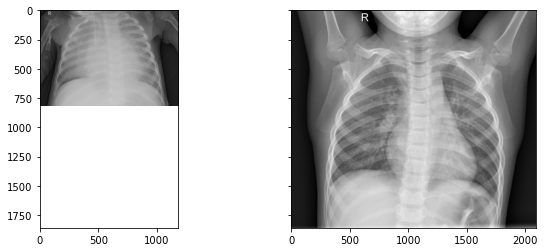

In [2]:

normal = io.imread('../input/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0115-0001.jpeg')

pneum = io.imread('../input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1004_bacteria_2935.jpeg')

f, axes = plt.subplots(1, 2, sharey=True)
f.set_figwidth(10)
    
axes[0].imshow(pneum, cmap='gray')
axes[1].imshow(normal, cmap='gray')

- The images have different sizes  and hence they have to be converted to a standard size.
- Dimension of 256,256 is chosen

# Model Building
  
   
## Preprocessing
   

In [3]:
def preprocess_img(img,mode):
       
    img_norm = (img - img.min())/(img.max() - img.min()) # normalise the images
    img_ret=img_norm
    if mode == 'train':
        if np.random.randn() > 0:
            img_ret = datagen.random_transform(img_ret) # transform the data only for a few cases
    return img_ret

## Augmentation using ImageDataGenerator

Using Augmented images helps in building a more generalized model

In [4]:
from keras.preprocessing.image import ImageDataGenerator
datagen=ImageDataGenerator(
                            featurewise_center=True,
                            featurewise_std_normalization=True,
                            rotation_range=10,
                            brightness_range=(1.2,1.8)
                           )

In [5]:
DATASET_PATH='../input/chest-xray-pneumonia/chest_xray/train/'
disease_cls = ['NORMAL', 'PNEUMONIA']
          

In [6]:
import numpy as np
import keras

class AugmentedDataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, mode='train', ablation=None, disease_cls = ['NORMAL', 'PNEUMONIA'], 
                 batch_size=64, dim=(256, 256), n_channels=1, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = {}
        self.list_IDs = []
        self.mode = mode
       
        for i, cls in enumerate(disease_cls):
            paths = glob.glob(os.path.join(DATASET_PATH, cls, '*'))
            brk_point = int(len(paths)*0.8)
            if self.mode == 'train':
                paths = paths[:brk_point]
            else:
                paths = paths[brk_point:]
            if ablation is not None:
                paths = paths[:int(len(paths)*ablation/100)]
            self.list_IDs += paths
            self.labels.update({p:i for p in paths})
        
        
            
        self.n_channels = n_channels
        self.n_classes = len(disease_cls)
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'

        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)
        
        delete_rows = []

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            img = io.imread(ID)
            img_rz=transform.resize(img,(256,256))
            img = img_rz[:, :, np.newaxis]
            if img.shape == (256, 256,1):
                img = preprocess_img(img, self.mode)
                X[i,] = img
                y[i] = self.labels[ID]
            else:
                delete_rows.append(i)
                continue
         
                
        X = np.delete(X, delete_rows, axis=0)
        y = np.delete(y, delete_rows, axis=0)
        
        return X, keras.utils.to_categorical(y, num_classes=self.n_classes)

### Model - ResNet50


In [1]:
img_channels=1
img_rows=256
img_cols=256
nb_classes=2

Since the images are in grayscale, they can't be directly fed into ResNet Architecture. Hence they are given as input to a 2D convolution network and the output frm this layer is given to ResNet model. It is then followed by Dense Networks 

In [7]:

base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols,3))

output = base_model.layers[-1].output
output = keras.layers.Flatten()(output)
base_model = Model(base_model.input,output)
for layer in base_model.layers:
    layer.trainable = False
    
   
x = Conv2D(3,(3,3),
           input_shape=(img_rows, img_cols,1),
           padding='same')

model = Sequential()
model.add(x)   
model.add(base_model)

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(2, activation='softmax'))
model.summary()


94674944/94668760 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 3)       30        
_________________________________________________________________
model (Model)                (None, 131072)            23564800  
_________________________________________________________________
flatten_1 (Flatten)          (None, 131072)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               33554688  
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________

## Custom Loss function

Since the dataset used is imbalanced a custom wieghted cross entropy loss function is used

In [8]:
from functools import partial
import tensorflow.keras.backend as K
from itertools import product

def w_categorical_crossentropy(y_true, y_pred, weights):
    nb_cl = len(weights)
    final_mask = K.zeros_like(y_pred[:, 0])
    y_pred_max = K.max(y_pred, axis=1)
    y_pred_max = K.reshape(y_pred_max, (K.shape(y_pred)[0], 1))
    y_pred_max_mat = K.cast(K.equal(y_pred, y_pred_max), K.floatx())
    for c_p, c_t in product(range(nb_cl), range(nb_cl)):
        final_mask += (weights[c_t, c_p] * y_pred_max_mat[:, c_p] * y_true[:, c_t])
    cross_ent = K.categorical_crossentropy(y_true, y_pred, from_logits=False)
    return cross_ent * final_mask


## Logging AUC

AUC is a better metric for model evaluation when dealing with imbalanced classes

In [9]:
from sklearn.metrics import roc_auc_score
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import *

class roc_callback(Callback):
    
    def on_train_begin(self, logs={}):
        logs['val_auc'] = 0

    def on_epoch_end(self, epoch, logs={}):
        y_p = []
        y_v = []
        for i in range(len(validation_generator)):
            x_val, y_val = validation_generator[i]
            y_pred = self.model.predict(x_val)
            y_p.append(y_pred)
            y_v.append(y_val)
        y_p = np.concatenate(y_p)
        y_v = np.concatenate(y_v)
        roc_auc = roc_auc_score(y_v, y_p)
        print ('\nVal AUC for epoch{}: {}'.format(epoch, roc_auc))
        logs['val_auc'] = roc_auc

## Compiling and Fitting the model
### Ablation run

In [10]:
bin_weights = np.ones((2,2))
bin_weights[0,0] = 3
bin_weights[0, 1] = 3
ncce = partial(w_categorical_crossentropy, weights=bin_weights)
ncce.__name__ ='w_categorical_crossentropy'

model.compile(loss=ncce,optimizer= 'Adam',metrics=['accuracy'])
training_generator = AugmentedDataGenerator('train', ablation=10)
validation_generator = AugmentedDataGenerator('val', ablation=10)

auc_logger = roc_callback()
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=5)
history=model.fit_generator(generator=training_generator,validation_data=validation_generator,
                    epochs=5, callbacks=[LR,auc_logger])

Epoch 1/5
6/6 [==============================] - ETA: 0s - loss: 0.9743 - accuracy: 0.7275
Val AUC for epoch0: 0.9744245524296675
6/6 [==============================] - 37s 6s/step - loss: 0.9743 - accuracy: 0.7275 - val_loss: 1.1435 - val_accuracy: 0.8710 - lr: 0.0010 - val_auc: 0.9744
Epoch 2/5
6/6 [==============================] - ETA: 0s - loss: 0.4699 - accuracy: 0.8777
Val AUC for epoch1: 0.9924585218702866
6/6 [==============================] - 37s 6s/step - loss: 0.4699 - accuracy: 0.8777 - val_loss: 0.5631 - val_accuracy: 0.9365 - lr: 0.0010 - val_auc: 0.9925
Epoch 3/5
6/6 [==============================] - ETA: 0s - loss: 0.4688 - accuracy: 0.8548
Val AUC for epoch2: 0.9934640522875817
6/6 [==============================] - 36s 6s/step - loss: 0.4688 - accuracy: 0.8548 - val_loss: 0.1260 - val_accuracy: 0.9688 - lr: 0.0010 - val_auc: 0.9935
Epoch 4/5
6/6 [==============================] - ETA: 0s - loss: 0.3816 - accuracy: 0.8910
Val AUC for epoch3: 0.9941690962099126
6/6 [=

# Final Run

In [11]:
bin_weights = np.ones((2,2))
bin_weights[0,0] = 3
bin_weights[0, 1] = 3
ncce = partial(w_categorical_crossentropy, weights=bin_weights)
ncce.__name__ ='w_categorical_crossentropy'

model.compile(loss=ncce,optimizer= 'Adam',metrics=['accuracy'])
training_generator = AugmentedDataGenerator('train')
validation_generator = AugmentedDataGenerator('val')

auc_logger = roc_callback()
filepath ='../input/output/kaggle/working/best_model.hdf5'
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=5)
checkpoint = ModelCheckpoint(filepath, monitor='val_auc', verbose=1, save_best_only=True, mode='max')

history=model.fit_generator(generator=training_generator,validation_data=validation_generator,
                    epochs=30, callbacks=[LR,auc_logger,checkpoint])

Epoch 1/30
65/65 [==============================] - ETA: 0s - loss: 0.3832 - accuracy: 0.8840
Val AUC for epoch0: 0.9940561103185925

Epoch 00001: val_auc improved from -inf to 0.99406, saving model to ../input/output/kaggle/working/best_model.hdf5
65/65 [==============================] - 430s 7s/step - loss: 0.3832 - accuracy: 0.8840 - val_loss: 0.2214 - val_accuracy: 0.9638 - lr: 0.0010 - val_auc: 0.9941
Epoch 2/30
65/65 [==============================] - ETA: 0s - loss: 0.2519 - accuracy: 0.9251
Val AUC for epoch1: 0.9960554186659749

Epoch 00002: val_auc improved from 0.99406 to 0.99606, saving model to ../input/output/kaggle/working/best_model.hdf5
65/65 [==============================] - 410s 6s/step - loss: 0.2519 - accuracy: 0.9251 - val_loss: 0.1174 - val_accuracy: 0.9679 - lr: 0.0010 - val_auc: 0.9961
Epoch 3/30
65/65 [==============================] - ETA: 0s - loss: 0.2320 - accuracy: 0.9357
Val AUC for epoch2: 0.9954927035079706

Epoch 00003: val_auc did not improve from 0

In [12]:
def plot_history(history):
    fig,axes = plt.subplots(1,2, figsize = (15, 5))   
    # plotting loss
    plt.subplot(121)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    
    # plotting accuracy
    plt.subplot(122)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')


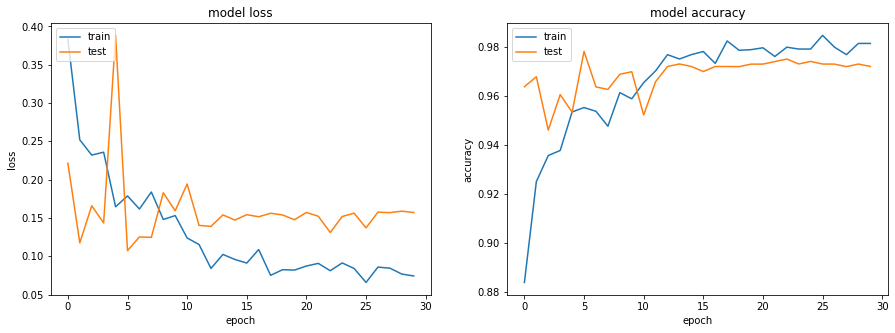

In [13]:
plot_history(history)

Training accuracy of 0.98 and a validation accuracy of 0.97 is achieved in 30 epochs. Validation AUC is 0.9970.